# Lasso regression on data smoothed with Gaussian (n = 10)

In [1]:
library(tidyverse)
library(glmnet)
library(glmnetUtils)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16

Warning message in install.packages("tidyr"):
“installation of package ‘

### Read in data and ATAC values, add ATAC values to the dataframe

In [3]:
#all_samples_gaussian_controls <- read.csv("../../../data/all_samples_normalized_gaussian_smooth_CONTROLS.csv", nrows=50000)
all_samples_gaussian_controls <- readRDS(snakemake@input[["input_train_data_std"]])

In [4]:
ATAC <- read.table(snakemake@input[["input_atac"]], header = FALSE)
colnames(ATAC) <- c("bin", "ATAC_observed")

ATAC$ATAC_observed <- as.character(ATAC$ATAC_observed)
ATAC$ATAC_observed <- as.numeric(ATAC$ATAC_observed)
ATAC$bin <- as.character(ATAC$bin)

all_samples_ATAC_gaussian_controls <- inner_join(all_samples_gaussian_controls, ATAC, by="bin")

head(all_samples_ATAC_gaussian_controls)

ERROR: Error in read.table(snakemake@input[["input_atac"]], header = FALSE): object 'snakemake' not found


In [ ]:
ATAC_val <- all_samples_ATAC_gaussian_controls %>% select(ATAC_observed)
controls_predictions <- all_samples_ATAC_gaussian_controls %>% select(sample, bin)
all_samples_ATAC_gaussian_controls = all_samples_ATAC_gaussian_controls %>% select(-c(ATAC_observed, sample, bin))

## Finding the best lambda

In [ ]:
get_cvm <- function(model) {
   index <- match(model$lambda.min, model$lambda)
  model$cvm[index]
}

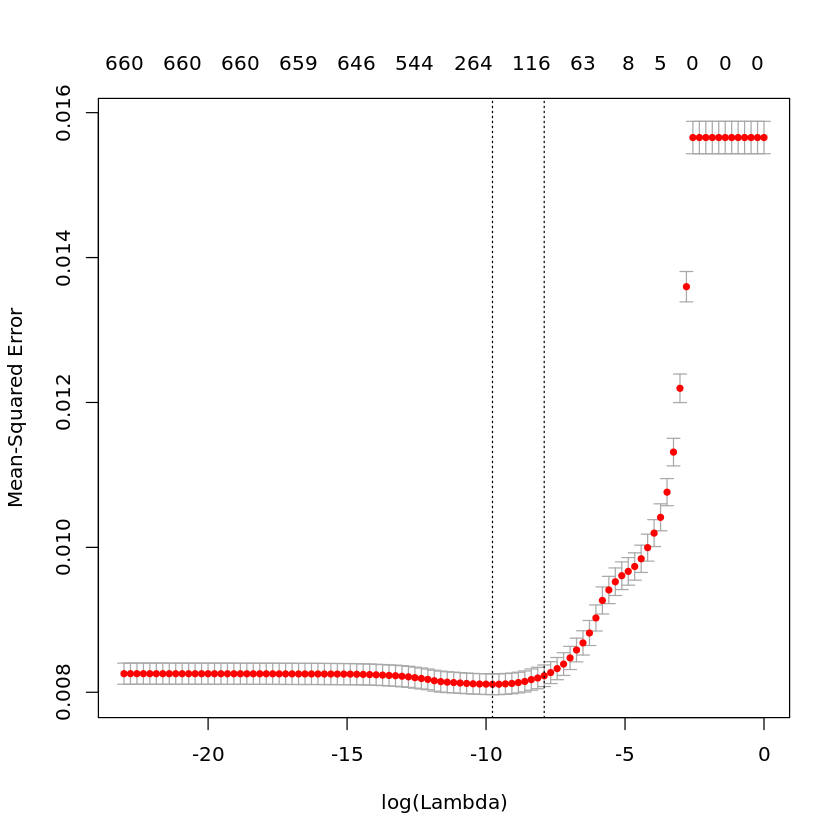

In [7]:
set.seed(0)
#X==predictor
#y==response
#sum_control_ATAC_bin_rm <- sum_control_ATAC  %>% dplyr::select(-bin)

y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_gaussian_controls %>% as.matrix()
#head(X)

######### finding the best alpha #########
set.seed(0)
lasso_cva <- cva.glmnet(X, y, nfolds = 10)
enet_performance <- data.frame(alpha = lasso_cva$alpha)
models <- lasso_cva$modlist
enet_performance$cvm <- vapply(models, get_cvm, numeric(1))

minix <- which.min(enet_performance$cvm)
best_alpha <- lasso_cva$alpha[minix]
###########################################

######### finding the best lambda #########
set.seed(0)
lasso_cv <- cv.glmnet(X, y, alpha = best_alpha,
                      standardize = TRUE, nfolds = 10)

plot(lasso_cv)
###########################################

In [8]:
(lambda_cv <- lasso_cv$lambda.min)

[1] 5.722368e-05

## Fit the model on all traindata controls

In [13]:
y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_gaussian_controls %>% as.matrix()

fit       <- glmnet(X, y, alpha = best_alpha, lambda = lambda_cv, standardize = TRUE)
# saving the model
saveRDS(fit, snakemake@output[["output_model"]])


## Predict on 20% normalized smoothed controls using the model (fitted on train controls) and save the predictions to the file

In [5]:
#filename = "../../../data/all_samples_normalized_gaussian_smooth_CASES.csv"
#filename = snakemake@input[["input_test_data_std"]]

test_data = readRDS(snakemake@input[["input_test_data_std"]])

In [ ]:
head(test_data)

In [ ]:
test_data_samples_bin_rm <- test_data %>% select(-c("sample", "bin")) %>% as.matrix()
tmp <- as.vector(predict(fit, s=lambda_cv, test_data_samples_bin_rm))

In [ ]:
pred_tibble <- tibble(sample = test_data$sample, bin = test_data$bin)
pred_tibble <- inner_join(pred_tibble, ATAC, by="bin")
pred_tibble <- pred_tibble %>% mutate(ATAC_predicted = tmp)

In [ ]:
ggplot(pred_tibble, aes(x = ATAC_observed, y = ATAC_predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

In [ ]:
cor(pred_tibble$ATAC_observed, pred_tibble$ATAC_predicted)

In [ ]:
ae    <- abs(pred_tibble$ATAC_observed - pred_tibble$ATAC_predicted)
(mae   <- mean(ae))

In [ ]:
se    <- (pred_tibble$ATAC_observed - pred_tibble$ATAC_predicted)^2
mse   <- mean(se)
(rmse <- sqrt(mse))

In [ ]:
saveRDS(pred_tibble, file = snakemake@output[["output_pred"]])